In [162]:
from numpy import *
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import itertools as it
import os.path as osp
import os
import helpers_06
from scipy.misc import imread
from scipy.misc import imresize
from scipy.ndimage import filters
from numpy import random
import matplotlib.image as mpimg
import urllib
import tensorflow as tf

%matplotlib inline

In [163]:
pretrained_weights, readable_labels = helpers_06.fetch_alexnet_weights_and_classes()

File bvlc_alexnet.npy already present.
File caffe_classes.py already present.


In [164]:
# pt stands for "pre-trained"
def pt_conv_layer(incoming, init_weight, init_bias,
                  strides=[1, 1], padding='SAME',
                  activation_fn=tf.nn.relu, 
                  name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        conv1W = tf.Variable(net_data["conv1"][0])
        conv1b = tf.Variable(net_data["conv1"][1])
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv1W, conv1b)
        a = activation_fn(z) if activation_fn is not None else z
        
        return a

In [165]:
# pt stands for "pre-trained"
def pt_alex_fc_layer(incoming, init_weights, init_biases, name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    with tf.name_scope('fully_connected'):
        return tf.nn.relu_layer(incoming, init_weights, init_biases, name=name)
    
def alex_lrn_layer(inputs):
    'lrn with some magic constants'
    return tf.nn.local_response_normalization(inputs, 2, 1.0, 2e-05, 0.75)

In [166]:
def pool_layer(incoming, ksize, strides, padding='VALID',
                pool_fn=tf.nn.max_pool, name=None):
    # pooling layer with stride padding
    ksize = [1] + ksize + [1]
    strides = [1] + strides + [1]    
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)
    

In [180]:
# pt stands for "pre-trained"
def pt_split_conv_layer(incoming, init_weight, init_bias,c_o, 
                        strides=[1, 1], padding='SAME',
                        activation_fn=tf.nn.relu, 
                        name=None,group=1):
    
    c_i = incoming.get_shape()[-1]
   
    assert c_i%group==0
    assert c_o%group==0
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'split_conv_layer'):
        w = tf.Variable(init_weight, name='kernel')
        b = tf.Variable(init_bias, name='bias')
        
        if group==1:
            conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        else: # ignoring the split part for now
            i_a, i_b = tf.split(incoming, group, 3, name='split_inputs')
            w_a, w_b = tf.split(w, group, 3, name='split_weights')

            conv_a = tf.nn.conv2d(i_a, w_a, strides, padding, name='conv_a')
            conv_b = tf.nn.conv2d(i_b, w_b, strides, padding, name='conv_b')
            conv = tf.concat([conv_a, conv_b], 3)
        
        z = tf.nn.bias_add(conv, b)
        a = activation_fn(z) if activation_fn is not None else z
        return a

def pool_layer(incoming, ksize, strides, padding='VALID',
                pool_fn=tf.nn.max_pool, name=None):
    # pooling layer with stride padding
    pool_fn=tf.nn.max_pool
    ksize = [1] + ksize + [1]
    strides = [1] + strides + [1]    
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)
    
def alexnet(images, init_weights,name=None):
    W=init_weights
    strides=[4,4]
    ksize=[11,11]
    conv1W = tf.Variable(W["conv1"][0])
    conv1b = tf.Variable(W["conv1"][1])
    conv1_in=pt_split_conv_layer(images,conv1W,conv1b,96,strides,padding='SAME',group=1,name="conv1_in")
    conv1 = tf.nn.relu(conv1_in)
    conv1=alex_lrn_layer(conv1)
    strides=[2,2]
    ksize=[3,3]
    maxpool1 =pool_layer(conv1,ksize,strides,padding='VALID',name="maxpool1")
    ###################################
    strides=[1,1]
    ksize=[5,5]
    conv2W = tf.Variable(W["conv2"][0])
    conv2b = tf.Variable(W["conv2"][1])
    conv2_in=pt_split_conv_layer(maxpool1,conv2W,conv2b,256,strides,padding='SAME',group=2,name="conv2_in")
    conv2 = tf.nn.relu(conv2_in)
    conv2=alex_lrn_layer(conv2)
    strides=[2,2]
    ksize=[3,3]
    maxpool2 =pool_layer(conv2,ksize,strides,padding='VALID',name="maxpool2")
    ###################################
    strides=[1,1]
    ksize=[3,3]
    conv3W = tf.Variable(W["conv3"][0])
    conv3b = tf.Variable(W["conv3"][1])
    conv3_in=pt_split_conv_layer(maxpool2,conv3W,conv3b,384,strides,padding='SAME',group=1,name="conv3_in")
    conv3 = tf.nn.relu(conv3_in)
    conv3=alex_lrn_layer(conv3)
    ##################################
    conv4W = tf.Variable(W["conv4"][0])
    conv4b = tf.Variable(W["conv4"][1])
    conv4_in=pt_split_conv_layer(conv3,conv4W,conv4b,384,strides,padding='SAME',group=2,name="conv4_in")
    conv4 = tf.nn.relu(conv4_in)
    conv4=alex_lrn_layer(conv4)
    #################################
    conv5W = tf.Variable(W["conv5"][0])
    conv5b = tf.Variable(W["conv5"][1])
    conv5_in=pt_split_conv_layer(conv4,conv5W,conv5b,256,strides,padding='SAME',group=2 ,name="conv5_in")
    conv5 = tf.nn.relu(conv5_in)
    conv5=alex_lrn_layer(conv5)
    strides=[1,1]
    strides=[2,2]
    ksize=[3,3]
    maxpool5 =pool_layer(conv5,ksize,strides,padding='VALID',name="maxpool5")
    ################################
    fc6W = tf.Variable(W["fc6"][0])
    fc6b = tf.Variable(W["fc6"][1])
    fc6=pt_alex_fc_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]),fc6W,fc6b,name="fc6")
    ###############################
    fc7W = tf.Variable(W["fc7"][0])
    fc7b = tf.Variable(W["fc7"][1])
    fc7=pt_alex_fc_layer(fc6,fc7W,fc7b,name="fc7")
    ###############################
    fc8W = tf.Variable(W["fc8"][0])
    fc8b = tf.Variable(W["fc8"][1])
    fc8=pt_alex_fc_layer(fc7,fc8W,fc8b,name="fc8")
    ##############################
    return fc8

In [206]:
class AlexNet_Model:
    def __init__(s, img_height, img_width, init_weights):  # non-standard, for abbreviation
        s.graph = tf.Graph()
        with s.graph.as_default():
            with tf.name_scope('inputs'):
                # consider two possibilities here:
                # 1.  use a fixed image size [img_height x img_width]
#                 s.images = tf.placeholder(tf.float32, 
#                                           shape=[None, img_height, img_width, 3], name="images")
                # 2.  use variable image sizes -and- rescale the images to the same size
                #     in a rescaling step (see name_scope('rescale')) ... note, one "batch"
                #     of images must all be the same size of image
                s.images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="images")

                # note, we don't need labels, b/c the work is already done for us (no fitting/training)
                
            with tf.name_scope('rescale'):
                s.scaled_images = tf.image.resize_images(s.images, [img_height, img_width])
            with tf.name_scope('alexnet'):  

                s.logits = alexnet(s.scaled_images, init_weights,name="alexnet")
                        
            with tf.name_scope('prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.arg_max(s.softmax, 1), tf.int32) # FIXME: unnecessary cast?

            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=s.graph)
        s.session.run(s.init)

    def save(s, _dir):
        # fixme:  save(session) versus export_meta_graph
        helpers_06.mkdir(_dir)
        with s.graph.as_default():
            tf.train.Saver().save(s.session, osp.join(_dir, "alexnet"))
        
        
    def predict(s, test_dict):
        pred, prob = s.session.run([s.prediction, s.softmax], feed_dict=test_dict)
        return pred, prob

In [207]:
# from above:
# pretrained_weights, readable_labels = helpers_06.fetch_alexnet_weights_and_classes()
mm = AlexNet_Model(227, 227, init_weights=pretrained_weights)
# init_weights=nit_weights=pretrained_weights
#  init_weights

In [208]:
img_names = ['dog', 'laska', 'poodle']
base_url = "http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/"
local_dir = "data/alexnet/"

for img_name in img_names:
    helpers_06.maybe_download("{}.png".format(img_name), base_url, local_dir)

File dog.png already present.
File laska.png already present.
File poodle.png already present.


/home/phoniex/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


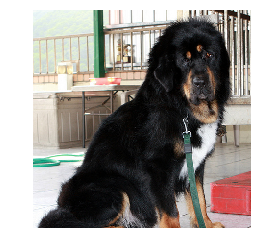

In [209]:
from scipy.misc import imread
import os.path as osp
img = imread(osp.join(local_dir, 'dog.png'))[:,:,:3]
plt.imshow(img)

plt.axis('off');

In [210]:
img_batch = np.expand_dims(img, 0)
img.shape

(227, 227, 3)

(227, 227, 3)


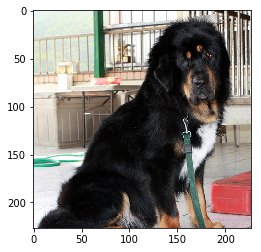

In [211]:
def show_image(img):
    img2=img
    print(img2.shape)


    plt.imshow(img) 
#     imgplot = plt.imshow(np.squeeze(img2), interpolation='nearest')

# which image?  we could select at random 
# pick_me = np.random.randint(len(test_data))
pick_me = 0
show_image(img_batch[0])
# print(train_labels[3])
# print(readable_labels[train_labels[3]])

In [212]:
mm = AlexNet_Model(227, 227, init_weights=pretrained_weights)
test_dict={mm.images:img_batch }
pred,probs=mm.predict(test_dict)


In [213]:
top5_indices = np.argsort(probs, 1)[0][-5:]

In [214]:
top5_indices

array([160, 267, 244, 256, 205])

In [215]:
for i in top5_indices:
    print(readable_labels[i])

Afghan hound, Afghan
standard poodle
Tibetan mastiff
Newfoundland, Newfoundland dog
flat-coated retriever


In [216]:
mm.save('saved_models')

In [217]:
# create a placeholder graph to "rehydrate" our freeze-dried AlexNet
old_alex_graph = tf.Graph()
with old_alex_graph.as_default():
    # importing the graph will populate new_alex_graph
    saver = tf.train.import_meta_graph("saved_models/alexnet.meta")